# Student Performance Prediction

The goal of this project is to predict student academic performance using machine learning techniques.
The project emphasizes **exploratory data analysis**, **data cleaning**, **feature selection** and **model comparison**.
Multiple regression models are evaluated to understand how different algorithms capture patterns in student performance data.


### Import Libraries

In [53]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Misc
import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [54]:
data = pd.read_csv("data/StudentPerformance.csv")

data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


### Basic Checks

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


We see there are no **NULL** Values in the data, but there are multiple **datatypes** 

In [56]:
data.shape

(10000, 6)

There are 10000 rows and 6 columns

In [57]:
data.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

In [58]:
data['Performance Index'].value_counts()

Performance Index
67.0     187
45.0     185
49.0     181
56.0     181
40.0     180
        ... 
14.0       7
99.0       6
11.0       5
100.0      3
10.0       1
Name: count, Length: 91, dtype: int64

Target variable **'Performance Index'** is a numeric variable with a wide range of ordered values, making regression appropriate

# EDA

In [59]:
# set visual style for plots
sns.set_theme(style="whitegrid")

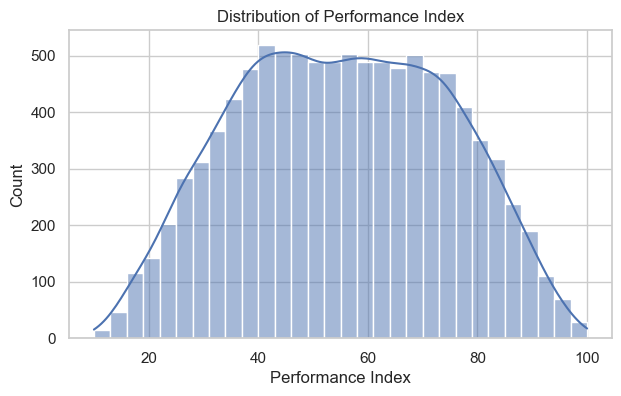

In [60]:
plt.figure(figsize=(7,4))
sns.histplot(data["Performance Index"], bins=30, kde=True)
plt.title("Distribution of Performance Index")
plt.show()

In [61]:
data["Performance Index"].skew()

np.float64(-0.001740027307220109)

The target variable shows near-zero skewness, indicating an approximately symmetric distribution. Therefore, no target transformation is necessary.

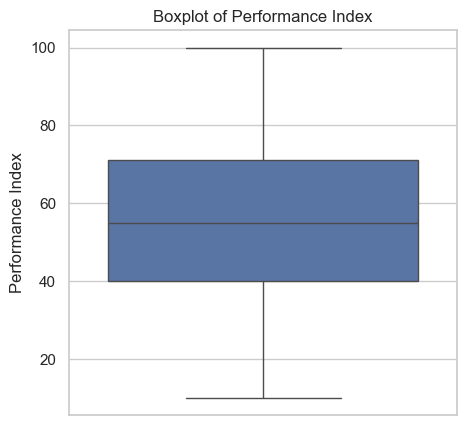

In [62]:
plt.figure(figsize=(5,5))
sns.boxplot(y=data["Performance Index"])
plt.title("Boxplot of Performance Index")
plt.show()

The target variable shows a balanced distribution with no significant outliers, indicating that no outlier treatment is required

Text(0.5, 1.0, 'Performance Index vs Sleep Hours')

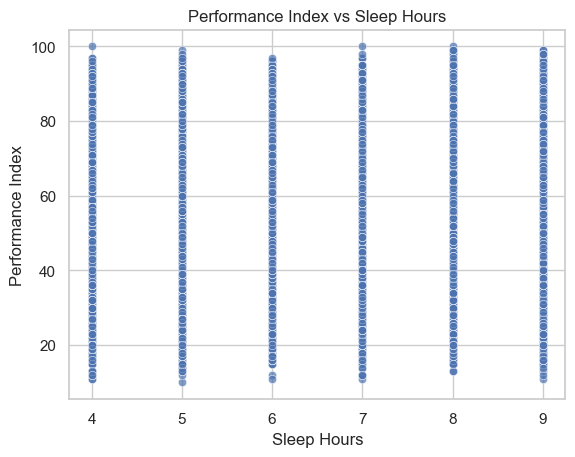

In [63]:
sns.scatterplot(x='Sleep Hours', y='Performance Index', alpha=0.7, data=data)
plt.title("Performance Index vs Sleep Hours")

In [64]:
data["Hours Studied"].corr(data["Sleep Hours"])

np.float64(0.0012451983990222713)

The scatter plot shows no strong linear relationship between sleep duration and performance index. For each sleep duration, performance values are widely spread, indicating that sleep hours alone are not a strong predictor of performance. However, sleep duration may still contribute to performance in combination with other factors.

Text(0.5, 1.0, 'Performance Index vs Hours Studied')

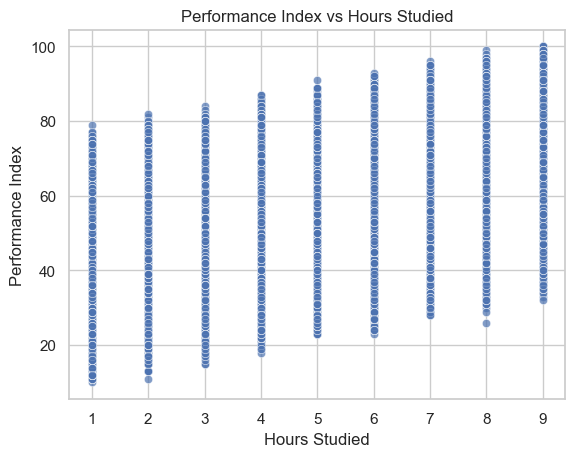

In [65]:
sns.scatterplot(x='Hours Studied', y='Performance Index', alpha=0.7, data=data)
plt.title("Performance Index vs Hours Studied")

In [66]:
data["Hours Studied"].corr(data["Performance Index"])

np.float64(0.37373035069872335)

The scatter plot shows a clear positive relationship between hours studied and performance index. As study time increases, performance tends to improve, although variability remains at each study level. This suggests that hours studied is a strong predictor of student performance.

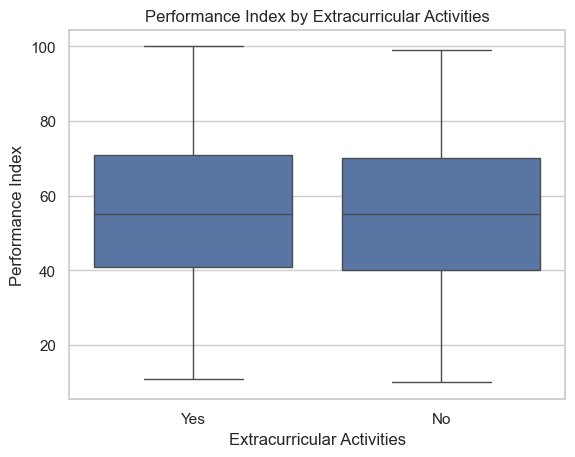

In [67]:
sns.boxplot(x=data["Extracurricular Activities"], y=data["Performance Index"])
plt.title("Performance Index by Extracurricular Activities")
plt.show()


The boxplot shows that the distribution of performance index is very similar for students with and without extracurricular activities. Median performance and variability are nearly identical, suggesting that extracurricular activities alone do not strongly differentiate student performance.

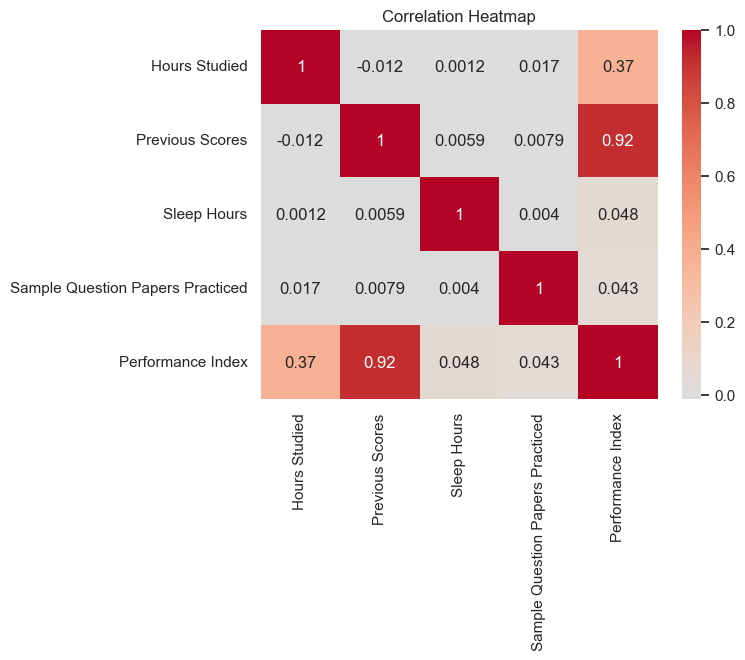

In [68]:
num_cols = data.select_dtypes(include=np.number).columns

sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


The correlation heatmap shows strong relationship between **Previous Scores** and **Performance Index**, indicating that past academic performance is the strongest predictor.
Hours studied shows a moderate positive correlation, suggesting a meaningful but less dominant contribution.
Additionally, low correlations among predictor variables indicate minimal multicollinearity, making the dataset well-suited for regression modeling.

# Data Preprocessing and Feature Engineering

In [69]:
missing_val= data.isnull().sum()
missing_val= missing_val[missing_val>0]
print(missing_val)
print("There are",len(missing_val),"columns which having NULL values")

Series([], dtype: int64)
There are 0 columns which having NULL values


In [70]:
data.shape

(10000, 6)

In [71]:
# Separate numerical columns
num_col = data.select_dtypes(include=np.number)

print("Numerical Columns: ", num_col)
print(len(num_col))

Numerical Columns:        Hours Studied  Previous Scores  Sleep Hours  \
0                 7               99            9   
1                 4               82            4   
2                 8               51            7   
3                 5               52            5   
4                 7               75            8   
...             ...              ...          ...   
9995              1               49            4   
9996              7               64            8   
9997              6               83            8   
9998              9               97            7   
9999              7               74            8   

      Sample Question Papers Practiced  Performance Index  
0                                    1               91.0  
1                                    2               65.0  
2                                    2               45.0  
3                                    2               36.0  
4                                    5     

In [72]:
# Separate categorical columns
cat_col = data.select_dtypes(include=['object', 'category'])

print("Categorical columns: ", cat_col)
print(len(cat_col))

Categorical columns:       Extracurricular Activities
0                           Yes
1                            No
2                           Yes
3                           Yes
4                            No
...                         ...
9995                        Yes
9996                        Yes
9997                        Yes
9998                        Yes
9999                         No

[10000 rows x 1 columns]
10000


In [73]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

There is no duplciated value in the data

In [74]:
num_col.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,9,1,91.0
1,4,82,4,2,65.0
2,8,51,7,2,45.0
3,5,52,5,2,36.0
4,7,75,8,5,66.0


In [75]:
num_col.skew()

Hours Studied                      -0.004213
Previous Scores                     0.004502
Sleep Hours                        -0.039474
Sample Question Papers Practiced   -0.035636
Performance Index                  -0.001740
dtype: float64

The skewness of all numerical features is close to zero, suggesting that the distributions are approximately symmetric and well-balanced

### Encoding from categorical data to numerical data

In [76]:
cat_col

,Extracurricular Activities
0,Yes
1,No
2,Yes
3,Yes
4,No
...,...
9995,Yes
9996,Yes
9997,Yes
9998,Yes


In [77]:
cat_col_encoded = cat_col["Extracurricular Activities"].map({"No" : 0, "Yes" : 1})

cat_col_encoded.head()

0    1
1    0
2    1
3    1
4    0
Name: Extracurricular Activities, dtype: int64

In [78]:
final_data = pd.concat([num_col, cat_col_encoded], axis=1)

final_data.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities
0,7,99,9,1,91.0,1
1,4,82,4,2,65.0,0
2,8,51,7,2,45.0,1
3,5,52,5,2,36.0,1
4,7,75,8,5,66.0,0


# Model Creation

### Splitting the dataset in X (input columns) and y (target columns)

In [79]:
X = final_data.drop(['Performance Index'], axis=1)
y = final_data['Performance Index']

In [80]:
X.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities
0,7,99,9,1,1
1,4,82,4,2,0
2,8,51,7,2,1
3,5,52,5,2,1
4,7,75,8,5,0


In [81]:
y.head()

0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
Name: Performance Index, dtype: float64

### Splitting X and y in **train test** format

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=21
)

In [83]:
print('shape of X_train',X_train.shape)
print('shape of X_test',X_test.shape)
print('shape of y_train',y_train.shape)
print('shape of y_test',y_test.shape)

shape of X_train (8000, 5)
shape of X_test (2000, 5)
shape of y_train (8000,)
shape of y_test (2000,)


### Scaling

In [84]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building and Evaluation

### Linear Regression

In [85]:
# Define model
model_lr = LinearRegression()

# Train model
model_lr.fit(X_train_scaled, y_train)

# Prediction on test
y_pred_lr = model_lr.predict(X_test_scaled)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression MSE: {mse_lr}')
print(f'Linear Regression R^2: {r2_lr}')

Linear Regression MSE: 4.187913060997726
Linear Regression R^2: 0.9888763071047979


### Ridge

In [86]:
# Define model
model_ridge = Ridge(alpha=1.0)

# Train model
model_ridge.fit(X_train_scaled, y_train)

# Prediction on test
y_pred_ridge = model_ridge.predict(X_test_scaled)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression MSE: {mse_ridge}")
print(f"Ridge Regression R^2: {r2_ridge}")

Ridge Regression MSE: 4.188179747554611
Ridge Regression R^2: 0.988875598747362


### Lasso

In [87]:
# Define model
model_lasso = Lasso(alpha=0.01, max_iter=10000)

# Train model
model_lasso.fit(X_train_scaled, y_train)

# Prediction on test
y_pred_lasso = model_lasso.predict(X_test_scaled)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression MSE: {mse_lasso}")
print(f"Lasso Regression R^2: {r2_lasso}")

Lasso Regression MSE: 4.1895266727090625
Lasso Regression R^2: 0.9888720211225276


### Random Forest

In [88]:
# Define model
model_rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

# Train model
model_rf.fit(X_train_scaled, y_train)

# Prediction on test
y_pred_rf = model_rf.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

Random Forest MSE: 5.397097963539563
Random Forest R^2: 0.9856645399755668


### Gradient Boosting

In [89]:
# Define model
model_gb = GradientBoostingRegressor(random_state=42)

# Train model
model_gb.fit(X_train_scaled, y_train)

# Prediction on test
y_pred_gb = model_gb.predict(X_test_scaled)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting MSE: {mse_gb}")
print(f"Gradient Boosting R^2: {r2_gb}")

Gradient Boosting MSE: 4.479282169798494
Gradient Boosting R^2: 0.98810238929938


### Results

In [90]:
results = pd.DataFrame({
    "Model": ["Linear Regression","Ridge","Lasso","Random Forest","Gradient Boosting"],
    "R2": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gb),
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_gb),
    ],
})

results["RMSE"] = np.sqrt(results["MSE"])

results.sort_values(by="R2", ascending=False)


,Model,R2,MSE,RMSE
0,Linear Regression,0.988876,4.187913,2.046439
1,Ridge,0.988876,4.188180,2.046504
2,Lasso,0.988872,4.189527,2.046833
4,Gradient Boosting,0.988102,4.479282,2.116431
3,Random Forest,0.985665,5.397098,2.323166


In [91]:
models = results["Model"]
r2_scores = results["R2"]
rmse_scores = results["RMSE"]

### R² Graph

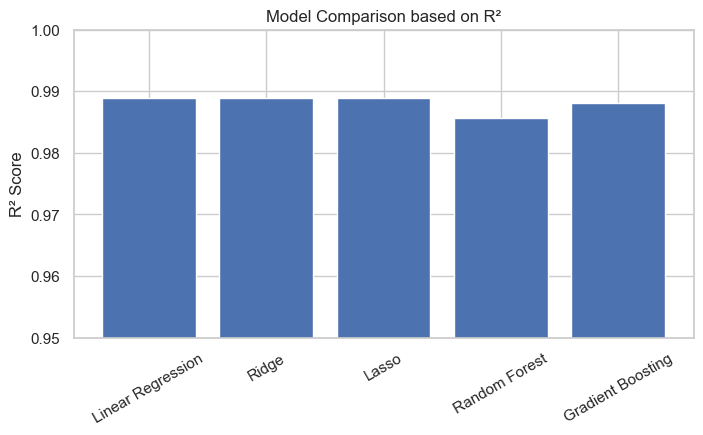

In [92]:
plt.figure(figsize=(8,4))
plt.bar(models, r2_scores)
plt.ylabel("R² Score")
plt.title("Model Comparison based on R²")
plt.xticks(rotation=30)
plt.ylim(0.95, 1.0)
plt.show()

Linear models achieved the highest R² scores, suggesting a predominantly linear relationship between features and the target variable

### RMSE Graph

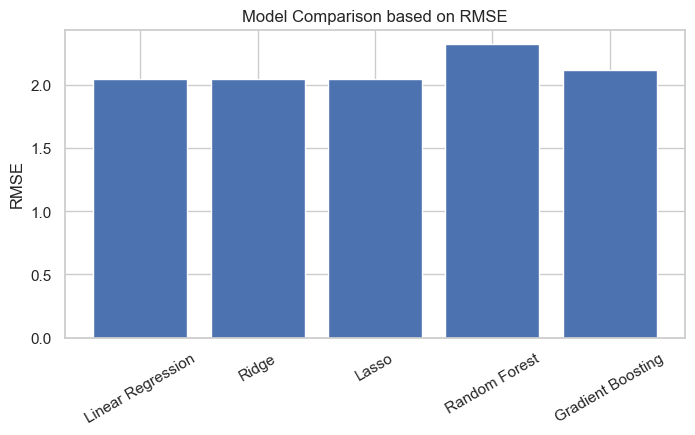

In [93]:
plt.figure(figsize=(8,4))
plt.bar(models, rmse_scores)
plt.ylabel("RMSE")
plt.title("Model Comparison based on RMSE")
plt.xticks(rotation=30)
plt.show()

RMSE results confirm that simpler linear models yield lower average prediction errors compared to more complex ensemble methods, reinforcing their suitability for this dataset

# Conlusion

In this student performance prediction project, multiple regression models were trained and evaluated using R² and RMSE metrics. Linear-based models (Linear Regression, Ridge, and Lasso) achieved the highest R² scores and the lowest RMSE values, indicating that they provide both strong explanatory power and accurate predictions.

The results suggest that the relationship between the input features and the target variable (Performance Index) is predominantly linear. More complex models such as Random Forest and Gradient Boosting did not offer significant performance improvements, confirming that simpler models are more suitable for this dataset. Overall, the project demonstrates the effectiveness of proper data preprocessing, feature engineering, and model comparison in building reliable regression models.

# Challenges

Several challenges were encountered during the development of this project:

1. **Feature Scaling and Data Leakage Prevention**  
   Proper feature scaling was required to ensure fair model comparison. Special attention was given to fitting the scaler only on the training data to avoid data leakage and ensure reliable evaluation results.

2. **Model Selection and Fair Comparison**  
   Choosing appropriate evaluation metrics was critical. Since the target variable was continuous, regression metrics (R² and RMSE) were used instead of classification metrics, enabling a fair and meaningful comparison across models.

3. **Balancing Model Complexity and Interpretability**  
   Although ensemble models were tested, their added complexity did not lead to better performance. Selecting a simpler linear model provided better interpretability while maintaining strong predictive accuracy.